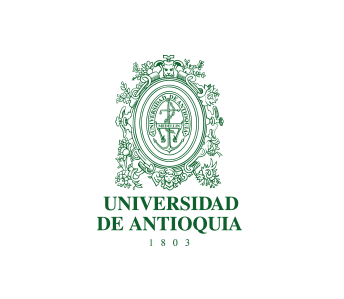

#**Proyecto 4: Clasificación de señales ECG**


Estudiantes:
- Juan Camilo Carvajal Sierra - 1010124738
- Ana María Uribe Betancur - 1000537653
- Duvan Vega Cardona - 1003896233

**Objetivos:**
Extraer características de señales que permitan construir sistemas de clasificación automática

In [ ]:
from scipy.stats import levene, shapiro, ttest_ind, mannwhitneyu
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import butter, filtfilt, find_peaks, freqz, detrend
import random
import scipy.signal as signal
import pywt
from statsmodels.nonparametric.smoothers_lowess import lowess
from skimage.restoration import denoise_nl_means, estimate_sigma
from statsmodels.robust import mad
import scipy.io as sio
from skimage.util import view_as_windows
from itertools import combinations

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight

In [ ]:
destination2 = 'Diagnostics.xlsx'

---

## 1. Revisión teórica.
---

 Del artículo:
https://www.nature.com/articles/s41598-020-59821-7
Hacer un resumen de la sección extracción de caracteríticas (Features extraction) y discutir desde el artículo y por lo menos otra referencia cómo se hace cuando desaparecen ciertas formas de ondas en el complejo PQRS debido a alguna enfermedad (10%)


***Optimal Multi-Stage Arrhythmia Classification Approach***

El estudio propone un método para la extracción de características del ECG que permite mejorar la clasificación de tipos de arritmias, centradas en relaciones geométricas y estadísticas entre los picos y valles de la señal ya que otros enfoques se centraban en atributos simples como amplitud y duración de ondas P, QRS y T, sin capturar suficientemente la variabilidad individual ni las distorsiones provocadas por condiciones cardíacas adicionales, como la onda P en AFIB. Además, factores como género, edad y etnia influyen en la amplitud y frecuencia de las señales.

Puntos clave son:
* Para reducir la variabilidad de amplitud, las señales ECG se reescalan (Normalización de amplitud) usando el método máximo-mínimo, unificando la escala antes de extraer las característica, ya que as diferencias individuales (género, edad, raza) generan variaciones significativas en amplitud y frecuencia.
* Los autores diseñaron 11 grupos distintos de características que van desde lo más simple hasta lo más exhaustivo.
* Se extrajeron características tradicionales como frecuencia ventricular, frecuencia auricular, duración del QRS, intervalo QT. Así mismo, en otro grupo se calcularon la media y varianza de los intervalos RR, conteo de intervalos RR, y la media/varianza de la altura, ancho y prominencia de los complejos QRS.
* Para capturar relaciones complejas, se calculan distribuciones de frecuencia empírica de las diferencias y razones entre alturas, anchos, prominencias y localizaciones temporales de picos y valles, considerando todas las combinaciones relevantes.
* Cada metodo se realiza inicialmente en la derivación II del ECG, obteniendo 3,300 variables:
 -  900 frecuencias: altura, ancho, prominencia para QRS, picos no-QRS y valles
 -  600 frecuencias: diferencias de ubicación
 -  1,800 frecuencias: ratios de diferencias sobre tiempo

El método se extiende a las 12 derivaciones del ECG, culminando en el Grupo más exhaustivo con 39,830 características.

Se muestra que esta estrategia, combinada con modelos como Extreme Gradient Boosting Trees (EGBT), ofrece un rendimiento equivalente o superior al de cardiólogos experimentados (F1-Score de hasta 0.992 con base de datos externa MIT-BIH).



---


***Advanced P Wave Detection in Ecg Signals During Pathology: Evaluation in Different Arrhythmia Contexts***


Este estudio presenta un método para detectar ondas P incluso cuando están ausentes o desordenadas como por ejemplo, por bloqueo AV de segundo grado o contracciones ventriculares prematuras (PVC). Primero, se identifica si un latido es PVC por medio de atributos como área bajo la curva, amplitud, duración de RR, y diferencias entre latidos.. Si lo es, se omite la búsqueda de P, ya que están ausentes. Si no es PVC,la señal ECG se filtra y luego se aplica una transformada de fase dentro de ventanas ajustadas alrededor del QRS (para las P, entre $ −0.7 × RR $ y $ −0.07 × RR $ antes de R(i)), lo cual resalta ondas de baja amplitud como la P, incluso cuando su amplitud es baja o está parcialmente oculta.

El algoritmo incorpora reglas basadas en el conocimiento médico:

* Decide si esperar o no la presencia de la onda P según el tipo de latido y el contexto clínico (por ejemplo, en bloqueo AV de segundo grado, algunas ondas P no son seguidas de QRS).

* En latidos donde la onda P puede estar ausente (como en PVC), el algoritmo evita buscarla para reducir falsos positivos.

* En presencia de arritmias, adapta la ventana de búsqueda de la onda P según la morfología y la secuencia de los latidos.

El método fue evaluado usando registros fisiológicos y patológicos del MIT-BIH Arrhythmia Database, con anotaciones manuales de expertos para la localización de las ondas P. Los resultados muestran una sensibilidad (Se) del 98.42% y una predictividad positiva (PP) del 99.98% en señales fisiológicas, y Se = 96.40%, PP = 85.84% en señales patológicas, superando ampliamente a métodos previos.

https://pmc.ncbi.nlm.nih.gov/articles/PMC6911105/pdf/41598_2019_Article_55323.pdf

---

## 2. Base de datos.
---

Del proyecto pasado hay dos opciones de base de datos, la filtrada
por los autores o la filtrada en el proyecto 3. De acuerdo a los resultados del proyecto 3 usar la mejor base de datos y justificar la selección.

La mejor base de datos es la filtrada en el articulo original, ya que usando esta base de datos se obtuvieron mayores comparaciones significativas entre pares de arritmias.

Seleccionar 4 tipos de arritmias, justificar los criterios, para el desarrollo de los puntos siguientes del trabajo.


Para continuar con el trabajo se seleccionaron 4 tipos de arritmias. Estas corresponden a las de mayor cantidad de datos. Estas son:
* Pacientes con Sinus Bradycardia (SB): 3889 - 44.09%
* Pacientes con Atrial Fibrillation (AFIB): 1780 - 20.18%
* Pacientes con Sinus Tachycardia (ST): 1568 - 17.78%
* Pacientes con Supraventricular Tachycardia (SVT): 587 - 6.66%

In [ ]:
datos = pd.read_excel('Diagnostics.xlsx')

rhythms_to_keep = ['SB', 'AFIB', 'ST', 'SVT']
datos_filtrados = datos[datos['Rhythm'].isin(rhythms_to_keep)].copy()

datos_2 = datos_filtrados[(datos_filtrados['PatientAge'] >= 18) & (datos_filtrados['PatientAge'] <= 90)].copy()
datos_finales = datos_2[(datos_2['Rhythm'] != 'AVNRT') & (datos_2['Rhythm'] != 'AVRT') & (datos_2['Rhythm'] != 'SAAWR')].copy()

display(datos_finales.head())

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


---

## PUNTO 3.
---
Con las características que estudiadas en el proyecto 1 y 2 generar un conjunto de características para el presente trabajo. Añadir las discutidas en el punto 1 del presente proyecto. Justificar la selección (15%).
Con estas características construir el dataframe de trabajo.

| Nombre de Registro de archivo | Arritmia | Característica 1 | Característica 2 | ... | Característica n|
|---|---|---|---|---|---|
|   |   |   |   |   |   |
|   |   |   |   |   |   |
|   |   |   |   |   |   |

In [ ]:
import librosa
from tqdm import tqdm
from scipy.fft import fft, fftfreq

ruta_ecgs = "ECGDataDenoised"
fs = 500  # Frecuencia de muestreo en Hz

# ---------- FUNCIONES AUXILIARES ----------

def extraer_derivacion_II(filepath):
    """Lee la segunda columna (índice 1) del archivo CSV"""
    return pd.read_csv(filepath, header=None).iloc[:, 1].values

def calcular_caracteristicas_temporales(signal_ecg, fs):
    peaks, _ = signal.find_peaks(signal_ecg, distance=0.6*fs)
    if len(peaks) < 2:
        return np.nan, np.nan, np.nan
    rr_intervals = np.diff(peaks) * (1000/fs)  # en milisegundos
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    rango = np.ptp(rr_intervals)
    return sdnn, rmssd, rango

def calcular_caracteristicas_espectrales(signal_ecg, fs):
    f, Pxx = signal.welch(signal_ecg, fs, nperseg=1024)

    # Frecuencia pico
    f_pico = f[np.argmax(Pxx)]

    # Ancho de banda espectral
    potencia_total = np.sum(Pxx)
    potencia_acumulada = np.cumsum(Pxx)
    f1 = f[np.searchsorted(potencia_acumulada, 0.25 * potencia_total)]
    f2 = f[np.searchsorted(potencia_acumulada, 0.75 * potencia_total)]
    ancho_banda = f2 - f1

    # Energía en la banda QRS (5-15 Hz)
    idx_band = np.where((f >= 5) & (f <= 15))
    energia_qrs = np.sum(Pxx[idx_band])

    return f_pico, ancho_banda, energia_qrs

def calcular_mfcc(signal_ecg, fs, n_mfcc=13, win_sec=2.0):
    """MFCC por ventanas, luego promedio, std y varianza"""
    mfccs = librosa.feature.mfcc(
        y=signal_ecg.astype(float),
        sr=fs,
        n_mfcc=n_mfcc,
        hop_length=int(fs * win_sec // 2),
        n_fft=int(fs * win_sec),
        htk=True
    )
    # Usamos el coeficiente 1 (ignorar el 0) para estabilidad
    mfcc1 = mfccs[1, :]
    return np.mean(mfcc1), np.std(mfcc1), np.var(mfcc1)

# ---------- PROCESAMIENTO PRINCIPAL ----------

caracteristicas = []

print("Extrayendo características de las señales ECG...")

for _, row in tqdm(datos_finales.iterrows(), total=len(datos_finales)):
    filename = row['FileName']
    path = os.path.join(ruta_ecgs, filename) + '.csv'
    try:
        ecg_signal = extraer_derivacion_II(path)

        # Temporales
        sdnn, rmssd, range_nni = calcular_caracteristicas_temporales(ecg_signal, fs)

        # Espectrales
        f_pico, ancho_banda, energia_qrs = calcular_caracteristicas_espectrales(ecg_signal, fs)

        # MFCC
        mfcc_mean, mfcc_std, mfcc_var = calcular_mfcc(ecg_signal, fs)

        # Consolidar
        caracteristicas.append({
            "FileName": filename,
            "Rhythm": row['Rhythm'],
            "sdnn": sdnn,
            "rmssd": rmssd,
            "range_nni": range_nni,
            "frecuencia_pico": f_pico,
            "ancho_banda_espectral": ancho_banda,
            "energia_banda_QRS": energia_qrs,
            "MFCC_Promedio": mfcc_mean,
            "MFCC_DesvStd": mfcc_std,
            "MFCC_Varianza": mfcc_var,
            # Clínicas
            "PatientAge": row["PatientAge"],
            "Gender": row["Gender"],
            "VentricularRate": row["VentricularRate"],
            "AtrialRate": row["AtrialRate"],
            "QRSDuration": row["QRSDuration"],
            "QTInterval": row["QTInterval"],
            "QTCorrected": row["QTCorrected"],
            "RAxis": row["RAxis"],
            "TAxis": row["TAxis"],
            "QRSCount": row["QRSCount"],
            "QOnset": row["QOnset"],
            "QOffset": row["QOffset"],
            "TOffset": row["TOffset"]
        })
    except Exception as e:
        print(f"Error con archivo {filename}: {e}")
        continue

# Crear DataFrame final
df_caracteristicas = pd.DataFrame(caracteristicas)

# Mostrar resumen
print("\nExtracción completada. Dimensiones del nuevo DataFrame:", df_caracteristicas.shape)
df_caracteristicas.head()
df_caracteristicas.to_csv("df_caracteristicas.csv", index=False)

Extrayendo características de las señales ECG...


  0%|          | 0/7616 [00:00<?, ?it/s]

100%|██████████| 7616/7616 [01:18<00:00, 97.39it/s] 



Extracción completada. Dimensiones del nuevo DataFrame: (7616, 24)


In [ ]:
# df_caracteristicas.to_csv('df_caracteristicas.csv', index=False)
df_caracteristicas = pd.read_csv('df_caracteristicas.csv')

---

## PUNTO 4
---
Código y análisis de resultados, donde se discutan por los menos tres diferentes arquitecturas de red y las matrices de confusión obtenidas (10%), de una red neuronal que permita la clasificación de las cuatro patologías cardiacas.

## Modelo 1: Red Neuronal Multicapa Simple (MLP básica)

Epoch 1/50


c:\Users\juanc\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8027 - loss: 0.5027 - val_accuracy: 0.8819 - val_loss: 0.2903
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8759 - loss: 0.3173 - val_accuracy: 0.9057 - val_loss: 0.2471
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8956 - loss: 0.2764 - val_accuracy: 0.9162 - val_loss: 0.2221
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9109 - loss: 0.2462 - val_accuracy: 0.9228 - val_loss: 0.2068
Epoch 5/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9159 - loss: 0.2280 - val_accuracy: 0.9189 - val_loss: 0.2008
Epoch 6/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9178 - loss: 0.2145 - val_accuracy: 0.9255 - val_loss: 0.2034
Epoch 7/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9238 - loss: 0.2073 - val_accuracy: 0.9294 - val_loss: 0.1936
Epoch 8/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9269 - loss: 0.1971 - val_accuracy: 0.9288 - val_

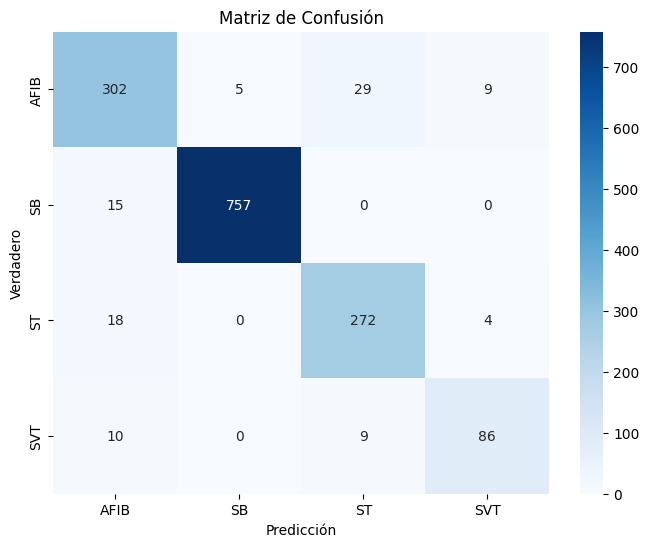

Reporte de Clasificación:

              precision    recall  f1-score   support

        AFIB       0.88      0.88      0.88       345
          SB       0.99      0.98      0.99       772
          ST       0.88      0.93      0.90       294
         SVT       0.87      0.82      0.84       105

    accuracy                           0.93      1516
   macro avg       0.90      0.90      0.90      1516
weighted avg       0.94      0.93      0.93      1516



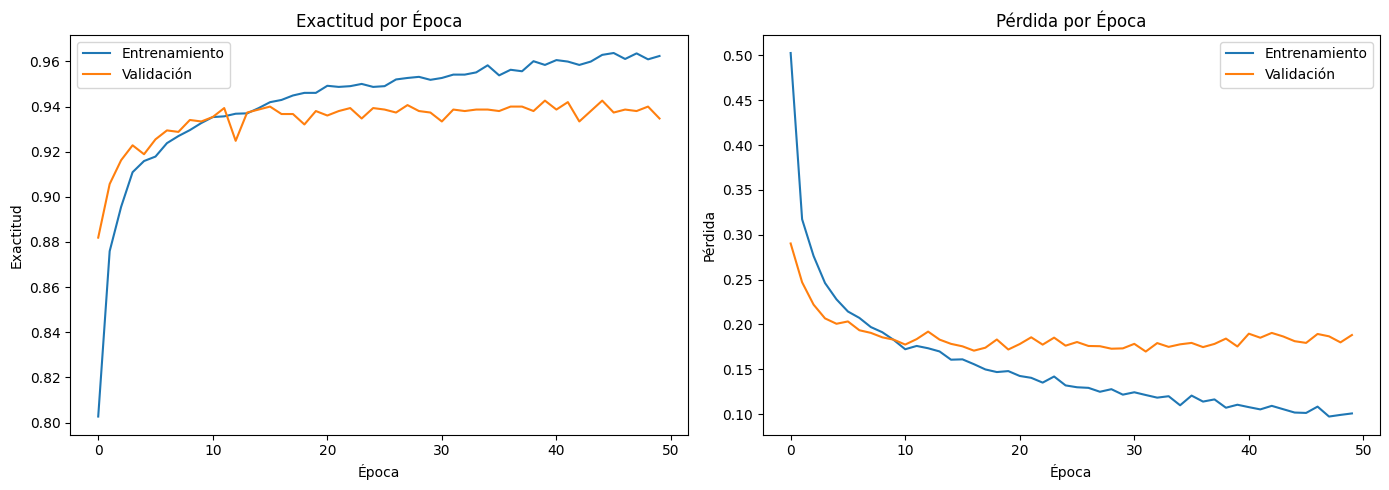

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import f1_score, accuracy_score

resumen_metricas = []  # inicializamos la lista vacía

def guardar_metricas(modelo, X_test, y_test, nombre_modelo, resumen=[]):
    y_true = np.argmax(y_test, axis=1)
    y_pred = np.argmax(modelo.predict(X_test), axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_por_clase = f1_score(y_true, y_pred, average=None)

    resumen.append({
        'Modelo': nombre_modelo,
        'Accuracy': acc,
        'F1_macro': f1_macro,
        'F1_SB': f1_por_clase[0],
        'F1_AFIB': f1_por_clase[1],
        'F1_ST': f1_por_clase[2],
        'F1_SVT': f1_por_clase[3]
    })
    return resumen

# === COPIA DEL DATAFRAME POR SEGURIDAD ===
df = df_caracteristicas.copy()

# === PREPROCESAMIENTO ===

# 1. Codificar 'Gender'
df['Gender'] = df['Gender'].map({'MALE': 1, 'FEMALE': 0})

# 2. Codificar etiquetas (Rhythm)
label_encoder = LabelEncoder()
df['RhythmEncoded'] = label_encoder.fit_transform(df['Rhythm'])  # 0–3
y = to_categorical(df['RhythmEncoded'])

# 3. Preparar X (excluir columnas no numéricas)
X = df.drop(columns=['FileName', 'Rhythm', 'RhythmEncoded'])

# 4. Forzar a valores numéricos y eliminar filas con NaN
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
y = y[df.index.isin(X.index)]

# 5. Escalar características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === DIVISIÓN DE DATOS ===
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# === DEFINICIÓN DEL MODELO MLP ===
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # 4 clases de arritmia
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# === ENTRENAMIENTO ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# === EVALUACIÓN ===

# Predicciones
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# === MATRIZ DE CONFUSIÓN ===
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

# === REPORTE DE CLASIFICACIÓN ===
print("Reporte de Clasificación:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# === GRÁFICAS DE ENTRENAMIENTO ===
plt.figure(figsize=(14,5))

# Exactitud
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Exactitud por Época')
plt.xlabel('Época')
plt.ylabel('Exactitud')
plt.legend()

# Pérdida
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida por Época')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.tight_layout()
plt.show()

# === GUARDAR MÉTRICAS DEL MLP ===
resumen_metricas = guardar_metricas(model, X_test, y_test, "MLP", resumen_metricas)



---



##Modelo 2: Red LSTM (Secuencial simulada)

Primero analizemos la distrubución de las clases.

In [ ]:
y_tiempo = df_caracteristicas['Rhythm'].values
y_rr = df_caracteristicas['Rhythm'].values  # Si es necesario

# Distribución de clases
valores_tiempo, cuentas_tiempo = np.unique(y_tiempo, return_counts=True)
valores_rr, cuentas_rr = np.unique(y_rr, return_counts=True)

print("Distribución clases: ")
for v, c in zip(valores_tiempo, cuentas_tiempo):
    print(f"{v}: {c}")

Distribución clases: 
AFIB: 1723
SB: 3859
ST: 1470
SVT: 564


De acuerdo a estos resultados realizaremos la preparación de los datos de entrada para una red neuronal LSTM (Long Short-Term Memory), siguiendo una estrategia de simulación secuencial por ventanas temporales. Esta arquitectura LSTM será utilizada para la clasificación de los cuatro tipos de arritmias cardíacas.

El procesamiento consistirá en lo siguiente:

1. Carga de las señales de ECG crudas desde archivos CSV, según la columna `FileName` del DataFrame `df_caracteristicas`.

2. Selección de la derivación II de cada señal (segunda columna).

3. Segmentación de cada señal en 100 ventanas temporales consecutivas de 50 muestras cada una, simulando pasos temporales.

4. Asignación de la etiqueta (arritmia) a cada señal desde la columna `Rhythm`.

5. Codificación one-hot de las etiquetas y balanceo de clases usando `class_weight`, porque, como se observó en la distribución de clases mostrada anteriormente, las muestras correspondientes a cada tipo de arritmia están desbalanceadas: por ejemplo, la clase SB tiene más de 3800 muestras, mientras que SVT apenas supera las 500. Este desbalance puede hacer que el modelo LSTM favorezca las clases mayoritarias y aprenda a ignorar las minoritarias, reduciendo la capacidad de detectar correctamente arritmias menos frecuentes pero clínicamente importantes. Al aplicar class_weight, se le da mayor importancia a los errores en clases poco representadas como SVT, promoviendo un aprendizaje más equilibrado entre todas las clases.

6. División de los datos en conjuntos de entrenamiento y prueba para evaluar el desempeño del modelo LSTM en una etapa posterior.

In [ ]:
# === Parámetros ===
ruta_ecg = "ECGDataDenoised"  # Carpeta de señales
fs = 500  # Hz
n_muestras = 5000  # Longitud de cada señal
tam_ventana = 50  # Muestras por ventana
pasos_temporales = n_muestras // tam_ventana  # 100 pasos

# === Función para cargar y procesar señales ===
def cargar_senales_por_ventanas(df, columna_archivo='FileName', columna_etiqueta='Rhythm'):
    X = []
    y = []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        archivo = row[columna_archivo]
        etiqueta = row[columna_etiqueta]
        path = os.path.join(ruta_ecg, archivo) + '.csv'
        try:
            señal = pd.read_csv(path, header=None).iloc[:, 1].values  # Derivación II
            if len(señal) == n_muestras:
                ventanas = señal.reshape(pasos_temporales, tam_ventana)
                X.append(ventanas)
                y.append(etiqueta)
        except Exception as e:
            print(f"Error con {archivo}: {e}")
    return np.array(X), np.array(y)

# === Cargar datos desde el DataFrame base ===
X_lstm, y_lstm = cargar_senales_por_ventanas(df_caracteristicas)

# === Codificar etiquetas ===
le = LabelEncoder()
y_lstm_encoded = to_categorical(le.fit_transform(y_lstm))
print("Clases codificadas:", le.classes_)

# === División entrenamiento / prueba ===
X_train, X_test, y_train, y_test = train_test_split(
    X_lstm, y_lstm_encoded, test_size=0.2, random_state=42, stratify=y_lstm)

# === Calcular class_weight para compensar desbalance ===
clases_train = np.argmax(y_train, axis=1)
pesos = class_weight.compute_class_weight(class_weight='balanced',
                                          classes=np.unique(clases_train),
                                          y=clases_train)
pesos_dict = dict(enumerate(pesos))

# === Verificación ===
print("Forma X:", X_train.shape)
print("Forma y:", y_train.shape)
print("¿NaN en X?:", np.isnan(X_train).any())
print("Pesos de clase:", pesos_dict)

100%|██████████| 7616/7616 [00:57<00:00, 132.56it/s]


Clases codificadas: ['AFIB' 'SB' 'ST' 'SVT']
Forma X: (6092, 100, 50)
Forma y: (6092, 4)
¿NaN en X?: False
Pesos de clase: {0: np.float64(1.1052249637155298), 1: np.float64(0.49335924846128926), 2: np.float64(1.2950680272108843), 3: np.float64(3.376940133037694)}


El resultado con forma (n_muestras, 100, 50) representa las señales segmentadas en pasos temporales simulados, y una matriz de etiquetas codificadas. Con los datos ya preparados pasaremos a integrar directamente el modelo LSTM con este conjunto y visualización de los resultados en entrenamiento y prueba.

In [ ]:
# === Importar librerías necesarias ===
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === Construcción del modelo LSTM ===
def construir_lstm(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# === Instanciar modelo ===
modelo_lstm = construir_lstm(input_shape=X_train.shape[1:])

# === Entrenamiento con class_weight ===
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = modelo_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    class_weight=pesos_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


c:\Users\juanc\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.7004 - loss: 0.9721 - val_accuracy: 0.8299 - val_loss: 0.4880
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8109 - loss: 0.6644 - val_accuracy: 0.8693 - val_loss: 0.3950
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8357 - loss: 0.5743 - val_accuracy: 0.8759 - val_loss: 0.3671
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8359 - loss: 0.6019 - val_accuracy: 0.8805 - val_loss: 0.3962
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8552 - loss: 0.5481 - val_accuracy: 0.8713 - val_loss: 0.3878
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8618 - loss: 0.4850 - val_accuracy: 0.8812 - val_loss: 0.3418
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8580 - loss: 0.4828 - val_accuracy: 0.8890 - val_loss: 0.3529
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.8680 - loss: 0.4575 - val_accuracy: 0.84

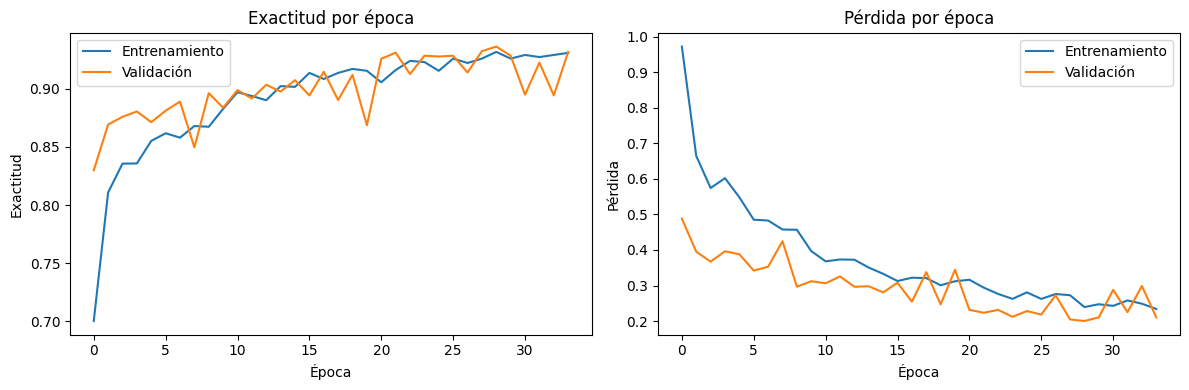

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Reporte de clasificación:

              precision    recall  f1-score   support

        AFIB       0.88      0.90      0.89       345
          SB       0.99      0.97      0.98       771
          ST       0.94      0.92      0.93       294
         SVT       0.77      0.86      0.81       113

    accuracy                           0.94      1523
   macro avg       0.89      0.91      0.90      1523
weighted avg       0.94      0.94      0.94      1523



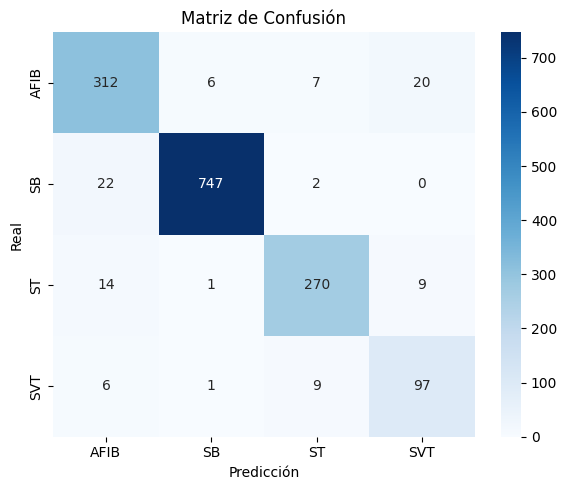

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [ ]:
# === Gráficas de exactitud y pérdida ===
def graficar_entrenamiento(historia):
    plt.figure(figsize=(12, 4))

    # Exactitud
    plt.subplot(1, 2, 1)
    plt.plot(historia.history['accuracy'], label='Entrenamiento')
    plt.plot(historia.history['val_accuracy'], label='Validación')
    plt.title('Exactitud por época')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.legend()

    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(historia.history['loss'], label='Entrenamiento')
    plt.plot(historia.history['val_loss'], label='Validación')
    plt.title('Pérdida por época')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.tight_layout()
    plt.show()

graficar_entrenamiento(hist)

# === Predicción en conjunto de prueba ===
y_pred_prob = modelo_lstm.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# === Reporte de clasificación ===
from sklearn.metrics import classification_report
print("Reporte de clasificación:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# === Matriz de confusión ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

# === GUARDAR MÉTRICAS DEL LSTM ===
resumen_metricas = guardar_metricas(modelo_lstm, X_test, y_test, "LSTM", resumen_metricas)

## Modelo 3. Red Neuronal Profunda con Batch Normalization

Epoch 1/50


c:\Users\juanc\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7387 - loss: 0.7112 - val_accuracy: 0.8557 - val_loss: 0.3606
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8459 - loss: 0.4044 - val_accuracy: 0.9151 - val_loss: 0.2301
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8641 - loss: 0.3664 - val_accuracy: 0.9209 - val_loss: 0.2202
Epoch 4/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8826 - loss: 0.3133 - val_accuracy: 0.9258 - val_loss: 0.1961
Epoch 5/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8861 - loss: 0.3005 - val_accuracy: 0.9217 - val_loss: 0.1898
Epoch 6/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8841 - loss: 0.2859 - val_accuracy: 0.9283 - val_loss: 0.1841
Epoch 7/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8960 - loss: 0.2673 - val_accuracy: 0.9242 - val_loss: 0.1862
Epoch 8/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9028 - loss: 0.2590 - val_accuracy: 0.9266 - val_

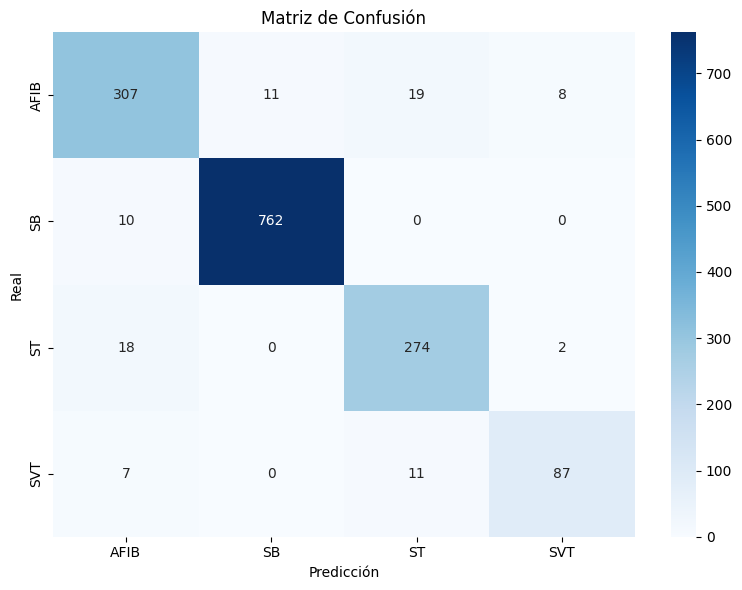

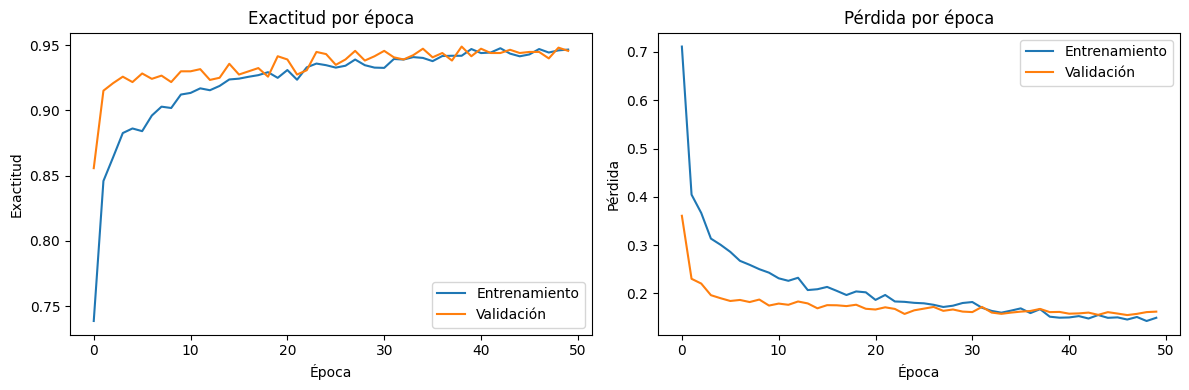

In [ ]:
# ====== LIBRERÍAS ======
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

# ====== 1. PREPROCESAMIENTO COMPLETO ======

# Copia del DataFrame
df = df_caracteristicas.copy()

# --- Codificar 'Gender' ---
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0, 'MALE': 1, 'FEMALE': 0})

# --- Codificar clase 'Arritmia' ---
label_encoder = LabelEncoder()
df['ArritmiaEncoded'] = label_encoder.fit_transform(df['Rhythm'])

# --- Variables predictoras ---
X = df.drop(columns=['FileName', 'Rhythm', 'ArritmiaEncoded'])

# --- Forzar conversión a numérico y eliminar NaNs ---
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()

# --- Actualizar etiquetas según índices válidos ---
y = df.loc[X.index, 'ArritmiaEncoded'].values

# --- Escalado ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- División en train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# ====== 2. MODELO DNN CON BATCH NORMALIZATION ======

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(4, activation='softmax')  # 4 clases
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# ====== 3. ENTRENAMIENTO ======

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# ====== 4. EVALUACIÓN ======

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPrecisión en test: {accuracy:.4f}")

# ====== 5. MATRIZ DE CONFUSIÓN ======

# Predicciones
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = label_encoder.classes_

# Reporte
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=labels))

from tensorflow.keras.utils import to_categorical

# Convertir y_test a one-hot solo para evaluación
y_test_onehot = to_categorical(y_test, num_classes=4)

# === Guardar métricas del modelo DNN + BatchNorm ===
resumen_metricas = guardar_metricas(model, X_test, y_test_onehot, "DNN+BN", resumen_metricas)

# Visualizar matriz de confusión
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

graficar_entrenamiento(history)

Comparamos los resultados:

<Figure size 1000x600 with 0 Axes>

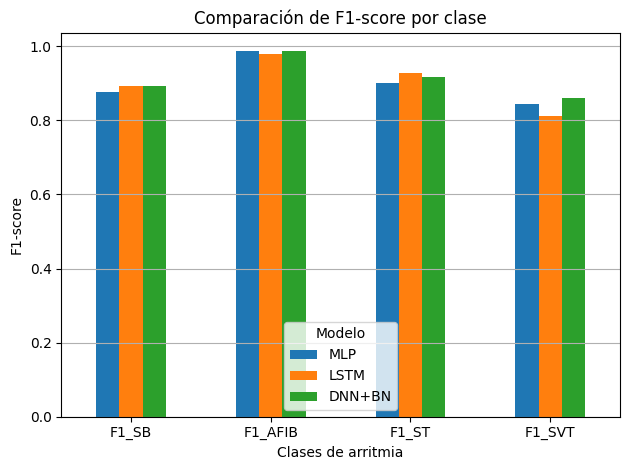

C:\Users\juanc\AppData\Local\Temp\ipykernel_17256\1179265173.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_resultados.reset_index(), x='Modelo', y='Accuracy', palette='Set2')


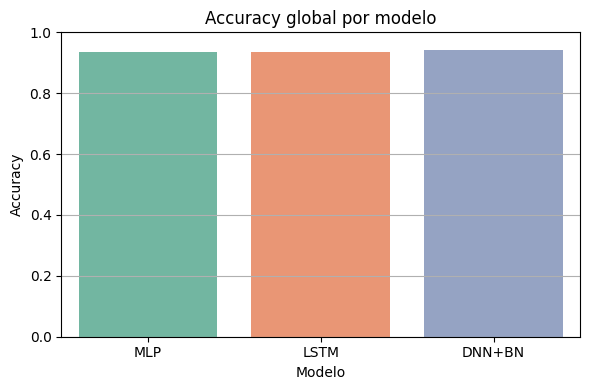

In [ ]:
df_resultados = pd.DataFrame(resumen_metricas)
df_resultados.set_index('Modelo', inplace=True)
df_resultados

# Seleccionar solo las columnas F1 por clase
df_f1_clases = df_resultados[['F1_SB', 'F1_AFIB', 'F1_ST', 'F1_SVT']].T

# Graficar
plt.figure(figsize=(10, 6))
df_f1_clases.plot(kind='bar')
plt.title("Comparación de F1-score por clase")
plt.xlabel("Clases de arritmia")
plt.ylabel("F1-score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title="Modelo")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=df_resultados.reset_index(), x='Modelo', y='Accuracy', palette='Set2')
plt.title("Accuracy global por modelo")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


---

## PUNTO 5
---
Código y análisis de resultados, donde se discutan por los menos tres diferentes arquitecturas de red y las matrices de confusión obtenidas (10%), de una red neuronal que permita la clasificación de dos de las cuatro patologías cardiacas.

Se escogen las dos patologías más representativas:

SB (Sinus Bradycardia): 772 muestras

AFIB (Atrial Fibrillation): 345 muestras

Esto con el fin de garantizar un dataset balanceado y clínicamente relevante: una arritmia auricular (AFIB) frente a una disfunción sinusal (SB).

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# 1. Copia del dataframe original
df = df_caracteristicas.copy()

# 2. Codificar el género
df['Gender'] = df['Gender'].map({'MALE': 1, 'FEMALE': 0})

# 3. Filtrar solo las dos clases de interés
df_bin = df[df['Rhythm'].isin(['SB', 'AFIB'])].copy()

# 4. Variables predictoras: convertir a numérico y descartar filas con NaN
X = df_bin.drop(columns=['FileName', 'Rhythm']).apply(pd.to_numeric, errors='coerce')
mask_valid = ~X.isna().any(axis=1)      # filas sin ningún NaN
X = X[mask_valid]

# 5. Etiquetas alineadas con las mismas filas válidas
y = df_bin.loc[mask_valid, 'Rhythm']

# 6. Codificar etiquetas (0 = AFIB, 1 = SB)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 7. Escalado estándar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 8. División train / test con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.20,
    stratify=y_encoded,
    random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train distribution:", np.bincount(y_train))


X_train shape: (4465, 22)
y_train distribution: [1378 3087]


#### Modelo 1: MLP Básico

c:\Users\juanc\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MLP - Reporte de clasificación:
              precision    recall  f1-score   support

        AFIB       0.97      0.97      0.97       345
          SB       0.99      0.99      0.99       772

    accuracy                           0.98      1117
   macro avg       0.98      0.98      0.98      1117
weighted avg       0.98      0.98      0.98      1117



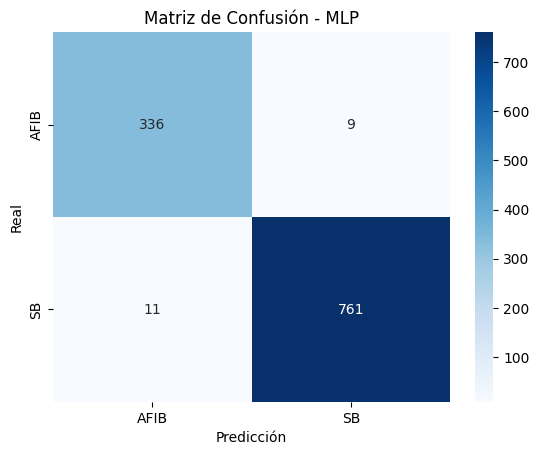

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binaria
])

model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=0)

# Evaluación
y_pred = (model1.predict(X_test) > 0.5).astype("int32")

print("MLP - Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - MLP")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


#### Modelo 2: MLP profundo con BatchNormalization

c:\Users\juanc\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
DNN + BatchNorm - Reporte de clasificación:
              precision    recall  f1-score   support

        AFIB       0.97      0.97      0.97       345
          SB       0.99      0.99      0.99       772

    accuracy                           0.98      1117
   macro avg       0.98      0.98      0.98      1117
weighted avg       0.98      0.98      0.98      1117



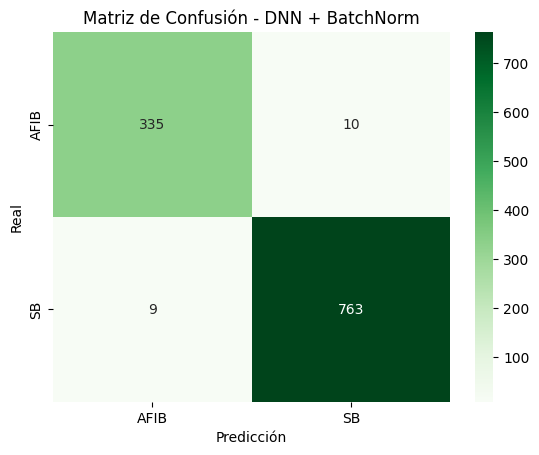

In [ ]:
from tensorflow.keras.layers import BatchNormalization

model2 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=0)

y_pred2 = (model2.predict(X_test) > 0.5).astype("int32")

print("DNN + BatchNorm - Reporte de clasificación:")
print(classification_report(y_test, y_pred2, target_names=label_encoder.classes_))

cm2 = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm2, annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - DNN + BatchNorm")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


#### Modelo 3: Red pequeña con solo una capa

c:\Users\juanc\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Modelo Simple - Reporte de clasificación:
              precision    recall  f1-score   support

        AFIB       0.97      0.97      0.97       345
          SB       0.99      0.99      0.99       772

    accuracy                           0.98      1117
   macro avg       0.98      0.98      0.98      1117
weighted avg       0.98      0.98      0.98      1117



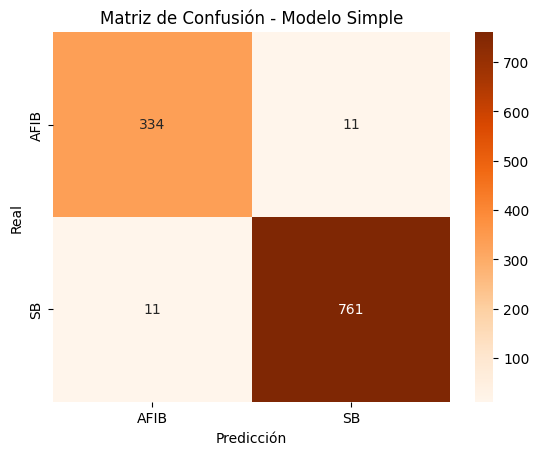

In [ ]:
model3 = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history3 = model3.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), verbose=0)

y_pred3 = (model3.predict(X_test) > 0.5).astype("int32")

print("Modelo Simple - Reporte de clasificación:")
print(classification_report(y_test, y_pred3, target_names=label_encoder.classes_))

cm3 = confusion_matrix(y_test, y_pred3)
sns.heatmap(cm3, annot=True, fmt="d", cmap="Oranges", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - Modelo Simple")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


---

## PUNTO 6
---
Implementar el código para hacer la clasificación usando XGBoost, discutir las matrices de confusión obtenidas (10%) para las cuatro patologías cardiacas.
Discutir los resultados respecto a  la mejor red neuronal (10%)

c:\Users\juanc\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:59:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9650395778364116

Reporte de clasificación:
              precision    recall  f1-score   support

        AFIB       0.94      0.93      0.94       345
          SB       0.99      0.99      0.99       772
          ST       0.94      0.96      0.95       294
         SVT       0.92      0.89      0.90       105

    accuracy                           0.97      1516
   macro avg       0.95      0.94      0.95      1516
weighted avg       0.96      0.97      0.96      1516



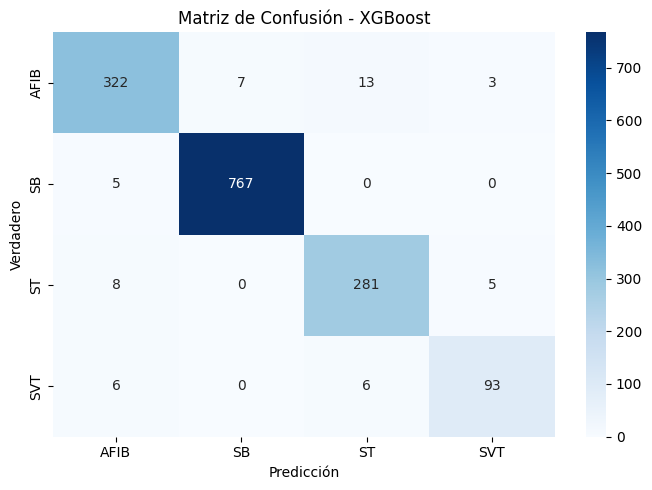

In [ ]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Copia del DataFrame
df = df_caracteristicas.copy()

# Codificar 'Gender' solo si no está ya como numérico
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0, 'MALE': 1, 'FEMALE': 0})

# Codificar etiqueta (Rhythm)
label_encoder = LabelEncoder()
df['RhythmEncoded'] = label_encoder.fit_transform(df['Rhythm'])  # valores de 0 a 3

# Preparar X e y
X = df.drop(columns=['FileName', 'Rhythm', 'RhythmEncoded'])
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
y = df.loc[X.index, 'RhythmEncoded']

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)
# Copia del DataFrame
df = df_caracteristicas.copy()

# Codificar 'Gender' solo si no está ya como numérico
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0, 'MALE': 1, 'FEMALE': 0})

# Codificar etiqueta (Rhythm)
label_encoder = LabelEncoder()
df['RhythmEncoded'] = label_encoder.fit_transform(df['Rhythm'])  # valores de 0 a 3

# Preparar X e y
X = df.drop(columns=['FileName', 'Rhythm', 'RhythmEncoded'])
X = X.apply(pd.to_numeric, errors='coerce')
X = X.dropna()
y = df.loc[X.index, 'RhythmEncoded']

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Instanciar el modelo con parámetros comunes para multiclase
modelo_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Entrenar
modelo_xgb.fit(X_train, y_train)

# Predicción
y_pred = modelo_xgb.predict(X_test)

# Accuracy general
print("Accuracy:", accuracy_score(y_test, y_pred))

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.tight_layout()
plt.show()


---

## PUNTO 7
---
Consultar cómo funciona, realizar y discutir un ejemplo con los datos, del algoritmo de K means (10%) y máquinas de soporte vectorial (SVM)  (10%)

K-Means es un algoritmo de clustering no supervisado que agrupa datos en k clústeres. Su objetivo es minimizar la distancia entre los puntos y el centroide del clúster al que pertenecen.

Etapas principales:

- Se eligen k centroides aleatorios.
-
- Cada punto se asigna al centroide más cercano.
-
- Se recalculan los centroides como la media de los puntos en cada clúster.
-
- Se repite hasta que los centroides no cambien significativamente.

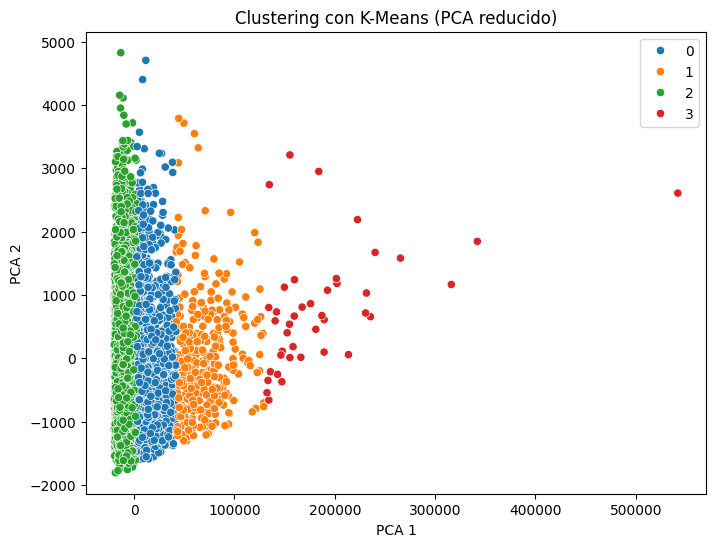

Adjusted Rand Index (comparado con etiquetas reales): 0.130


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Copia del dataframe y preprocesamiento
df = df_caracteristicas.copy()
df['Gender'] = df['Gender'].map({'MALE': 1, 'FEMALE': 0})

# Eliminar columnas no numéricas
X = df.drop(columns=['FileName', 'Rhythm'])
X = X.apply(pd.to_numeric, errors='coerce').dropna()

# Etiquetas verdaderas (para comparación)
y_true = df.loc[X.index, 'Rhythm'].values

# Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# K-Means con k=4 (por las 4 arritmias)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

# Visualización
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='tab10', legend='full')
plt.title('Clustering con K-Means (PCA reducido)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# Evaluación con etiquetas verdaderas
ari = adjusted_rand_score(y_true, clusters)
print(f"Adjusted Rand Index (comparado con etiquetas reales): {ari:.3f}")


SVM es un algoritmo supervisado que encuentra el hiperplano que mejor separa las clases. Puede ser lineal o usar kernels para fronteras no lineales.

Ventajas:

- Muy efectivo en espacios de alta dimensión.
- Robusto frente al sobreajuste en algunos casos.

Reporte de clasificación SVM:
              precision    recall  f1-score   support

        AFIB       0.91      0.86      0.88       345
          SB       0.98      0.99      0.99       772
          ST       0.86      0.91      0.89       294
         SVT       0.89      0.85      0.87       105

    accuracy                           0.94      1516
   macro avg       0.91      0.90      0.91      1516
weighted avg       0.94      0.94      0.94      1516



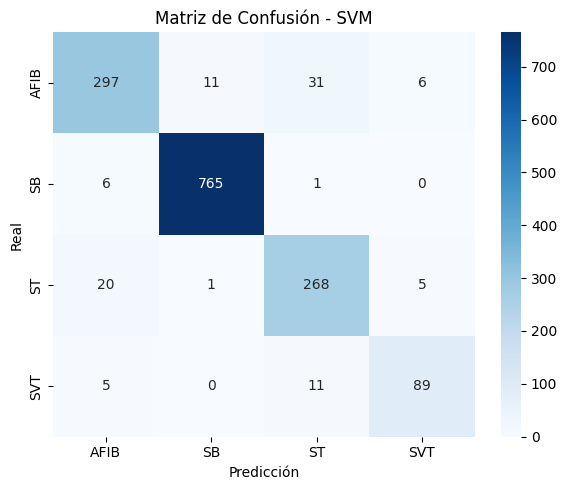

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Preprocesamiento
df = df_caracteristicas.copy()
df['Gender'] = df['Gender'].map({'MALE': 1, 'FEMALE': 0})

X = df.drop(columns=['FileName', 'Rhythm'])
X = X.apply(pd.to_numeric, errors='coerce').dropna()
y = df.loc[X.index, 'Rhythm']

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Escalar y dividir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Entrenar SVM (con kernel RBF)
svm_model = SVC(kernel='rbf', C=1, gamma='scale')
svm_model.fit(X_train, y_train)

# Evaluar
y_pred = svm_model.predict(X_test)

# Reporte
print("Reporte de clasificación SVM:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


---

## PUNTO 8
---
Hacer un informe con todos los puntos anteriores (10%). En el informe incluir:
Consultar por lo menos tres equipos comerciales que traen ya incorporados
algoritmos de ayuda diagnóstica a partir de señales EKG (5%) y discutir
brevemente las funcionalidades desde la teoría vista en el curso (10%)

En la actualidad, diversos equipos comerciales de electrocardiografía han incorporado algoritmos de ayuda diagnóstica que automatizan la interpretación de señales ECG, facilitando la detección temprana de arritmias y otras alteraciones cardíacas.

Entre estos, se encuentra el **Philips PageWriter TC70**, un electrocardiógrafo clínico que incorpora el algoritmo DXL de 16 derivaciones, capaz de generar más de 600 interpretaciones automáticas, incluyendo la detección de arritmias, anomalías en el segmento ST, ejes cardíacos y valores corregidos del complejo QT. Este sistema utiliza análisis morfológico de las ondas P, QRS y T, junto con mediciones precisas de intervalos temporales, lo cual se relaciona directamente con las técnicas de extracción de características temporales vistas en el curso, como la identificación de picos R y la medición de variabilidad. En Colombia, el equipo es distribuido por Philips y se encuentra en uso en instituciones hospitalarias de nivel II y III [1].

Por otro lado, el **GE MAC 5500 HD**, equipado con el algoritmo Marquette 12SL, es un electrocardiógrafo clínico avanzado que ofrece interpretación automatizada mediante el análisis de ritmo, eje, intervalos (PR, QRS, QT) y segmentos ST-T. Uno de sus aportes técnicos más destacados es su capacidad para aplicar filtros digitales que reducen el ruido de alta frecuencia (como interferencia muscular o electromagnética) y para realizar corrección de la línea base, compensando desplazamientos debidos a respiración o movimiento. Estos procesos están alineados con lo visto en el curso en relación con el preprocesamiento de bioseñales, donde se enfatiza la importancia de eliminar artefactos y estabilizar la señal antes de extraer características como picos R o intervalos RR. Al aplicar estas técnicas en tiempo real, el MAC 5500 HD mejora la precisión de sus algoritmos de detección y permite decisiones clínicas más confiables. Este equipo se distribuye en Colombia a través de GE Healthcare [2].

Finalmente, el **CardioSecur Pro**, desarrollado por Personal MedSystems GmbH, es un sistema portátil de monitoreo ECG que utiliza cuatro electrodos para reconstruir hasta 22 derivaciones, transmitiendo los datos a una aplicación que realiza análisis automático en la nube. El equipo aplica dos técnicas clave del procesamiento de bioseñales que fueron abordadas en el curso: el análisis por ventanas temporales y la normalización de la señal. A través de la segmentación de la señal ECG en bloques cortos, el sistema permite la extracción eficiente de características dinámicas como los intervalos RR o la morfología de los complejos QRS, facilitando la detección en tiempo real de arritmias como fibrilación auricular o bradicardia. Esta segmentación mejora la respuesta del algoritmo ante eventos breves y reduce la latencia de interpretación. Además, el sistema aplica una normalización por ventana que estandariza la señal (media cero y varianza unitaria), lo que mejora la robustez del modelo frente a variaciones interpaciente y permite el uso de clasificadores livianos. Estos dos componentes, fundamentales en tareas de clasificación automática, refuerzan la precisión diagnóstica del dispositivo en contextos ambulatorios [3].

Fuentes:
- https://www.philips.com.co/healthcare/product/HC860315/cardigrafos-pagewriter-tc70-cardigrafo#features
- https://www.gehealthcare.co.uk/-/jssmedia/global/uk/diagnostic-cardiology/2018/06/18/marquette-12sl-algorithm.pdf?utm_source=chatgpt.com
- https://www.cardiosecur.com/